**Table of contents**<a id='toc0_'></a>    
- [Mise en place](#toc1_)    
  - [Chargement des données](#toc1_1_)    
  - [Préparation des données](#toc1_2_)    
- [Approches Bag-of-words](#toc2_)    
  - [Méthode de scoring](#toc2_1_)    
- [TF-IDF](#toc3_)    
- [CountVectorizer](#toc4_)    
- [LDA](#toc5_)    
  - [Topic → prédiction de mots](#toc5_1_)    
- [NMF](#toc6_)    
- [Conclusion](#toc7_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=2
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[Mise en place](#toc0_)

In [1]:
# DS
import numpy as np
import pandas as pd

# ML
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
import pyLDAvis
import pyLDAvis.lda_model
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import NMF
from Levenshtein import ratio

# home made functions from the src folder
from src.scrap_and_clean import init_data
from src.models import results_from_vec_matrix
from src.models import score_reduce
from src.models import plot_model
from src.models import plot_topic_model
from src.models import eval_lda_n_topics
from src.models import get_topics

## <a id='toc1_1_'></a>[Chargement des données](#toc0_)

In [2]:
df_pp = init_data()

INFO:root:✅ Preprocessed data loaded


In [3]:
print(f"DF shape: {df_pp.shape}")
display(df_pp.head())

DF shape: (49975, 10)


,doc_bow,tags,score,answers,views,date,title_bow,title,body_bow,body
0,itms-91053 missing api declaration privacy sud...,ios app-store plist,24,7,3092,2024-03-14 22:55:18,itms-91053 missing api declaration privacy,ITMS-91053: Missing API declaration - Privacy,suddent successful build apple,<p>Why am I all of a suddent getting this on s...
1,builtin sorted slower list containing descendi...,python algorithm performance sorting time-comp...,28,2,2699,2024-03-05 15:21:50,builtin sorted slower list containing descendi...,Why is builtin sorted() slower for a list cont...,sorted four similar list list consistently tak...,<p>I sorted four similar lists. List <code>d</...
2,std :shared_mutex :unlock_shared block though ...,c++ windows multithreading stl,26,5,1388,2024-03-01 23:09:59,std :shared_mutex :unlock_shared block though ...,std::shared_mutex::unlock_shared() blocks even...,team encountered deadlock suspect bug windows ...,<p>My team has encountered a deadlock that I s...
3,rules nullptr init unique_ptr c++ compiles msv...,c++ visual-c++ language-lawyer unique-ptr c++23,15,1,490,2024-02-22 11:29:42,rules nullptr init unique_ptr c++,Did the rules for nullptr init of unique_ptr c...,compiles msvc c++ mode failes c++ mode current...,<p>This code compiles with MSVC from VS 2022 i...
4,order elf relocation applied specified conside...,c++ elf dynamic-linking abi,16,1,1746,2024-02-19 21:42:03,order elf relocation applied specified,Where is the order in which ELF relocations ar...,consider linux system use_message.cpp libmessa...,<p>Consider the following two files on a Linux...


Utilisation des données indispensables seulement

In [4]:
df = df_pp[["doc_bow", "tags"]]
print(f"DF shape: {df.shape}")

DF shape: (49975, 2)


## <a id='toc1_2_'></a>[Préparation des données](#toc0_)

Séparation de 1000 documents pour les tests, le reste pour l'entraînement des modèles.

In [5]:
random_state = 42
test_size = 1000

# X, y, train, test split
X_train, X_test, y_train, y_test = train_test_split(
    df["doc_bow"], df["tags"], test_size=test_size, random_state=random_state
)

# <a id='toc2_'></a>[Approches Bag-of-words](#toc0_)

> RAPPEL :  
> La colonne `doc_bow` est un ***bag of words*** (abrégé *BOW*), dans lequel tous les mots d'un document y sont représentés, sans aucune distinction (ni ordre).  

Cette approche permet de représenter chaque document par un vecteur de la taille du vocabulaire entier (corpus), soit par un comptage soit par une fréquence (cf. ci-après)

## <a id='toc2_1_'></a>[Méthode de scoring](#toc0_)

On cherche à évaluer l'efficacité d'un modèle qui renvoie deux listes de termes, **sans toutefois appliquer de solution binaire** comme la présence ou non du terme exact dans les deux listes, au vu de la **diversité des termes employés**.  

Une **solution métier sur-mesure** est envisageable comme un **taux de couverture des tags existants**, e.g. l'utilisation du meilleur ratio de Levenshtein (similarité entre chaînes de caractères) avec un seuil cohérent, qui sera divisé par le nombre de termes.

> Une similarité de 70% permet par exemple de mettre une similarité de 0 entre 'c' et 'c#', une similarité de 0.71 entre 'spring' et 'spring-boot' mais de 0 entre 'spring-boot' et 'boot'.



- le score maximum de 1 équivaut à tous les termes exacts trouvés,
- le minimum de 0 signifie qu'il n'y a pas eu de terme suffisamment proche pour passer le seuil défini

In [6]:
def score_terms(pred_words, target_words, cutoff=0.7) -> float:
    """Return a score of terms similarity between 2 lists of strings"""
    score = 0
    for p_w in pred_words:
        score += max(ratio(t, p_w, score_cutoff=cutoff) for t in target_words)
    score = np.round(score / len(target_words), 3)

    return score

La **limite** de cette solution, **basée sur les tags existants, est la pertinence** de ceux-ci.

# <a id='toc3_'></a>[TF-IDF](#toc0_)

Un modèle simple de prédictions se basant sur les fréquences de monogrammes présents dans un corpus.

Le modèle TF-IDF (Term Frequency - Inverse Document Frequency) est basé sur la **fréquence des termes dans un corpus de documents**.  
- TF : la première étape consiste à calculer la fréquence d'un terme dans un document
- IDF : la seconde étape est la diminution du poids des mots les plus fréquents dans le corpus (log de la division du nombre de documents par le nombre de documents contenant le mot, lissé +1 pour éviter les divisions par zéro)

Il renvoie une matrice de poids de chaque terme pour chaque document.

Cela revient à dire : "ces mots sont davantage utilisés ici qu'ailleurs dans le corpus, ils doivent donc être importants".

[Documentation ScikitLearn](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)

Entraînement du modèle sur l'échantillon d'entraînement

In [7]:
tfidf_vectorizer = TfidfVectorizer(token_pattern=r"\S+", min_df=10)
tfidf_fitted = tfidf_vectorizer.fit(X_train)
tfidf_names = tfidf_vectorizer.get_feature_names_out()

Exemple sur un document du test

In [8]:
# get a random example in test set
random_i = 42
example_doc_index = X_test.index[random_i]
doc = X_test[example_doc_index]

# get target
y = y_test[example_doc_index].split(" ")

# predict
X = tfidf_fitted.transform(X_test)
doc_transformed = X[random_i]

# original data
origin_doc = df_pp.iloc[example_doc_index]

# display predictions
predictions = results_from_vec_matrix(tfidf_names, doc_transformed)
pred_words = [p[0] for p in predictions]


print(f"🔹 Original document:\n\t{origin_doc[['title', 'body']].values}\n")
print(f"🔹 Preprocessed data:\n\t{doc}\n")
print(f"🔹 Predictions:\n\t{pred_words}\n")
print(f"🔹 Targetted tags:\n\t{y}\n")
print(f"🔹 Score:\n\t{score_terms(pred_words, y)}\n")

🔹 Original document:
	['Can I find an element using regex with Python and Selenium?'
 "<p>I need to click a dropdown list and click a hidden element with in it. the html will be generated by javascript and I won't know the id or class name but I will know it will have a phrase in it. Can I find and element by regex and then click it with selenium?</p>\n"]

🔹 Preprocessed data:
	find element regex python selenium click dropdown list click hidden element html generated javascript class name phrase find element regex click selenium

🔹 Predictions:
	['regex', 'click', 'element', 'selenium', 'phrase']

🔹 Targetted tags:
	['javascript', 'python', 'html', 'regex', 'selenium']

🔹 Score:
	0.4



Application sur nos données de test

In [9]:
tfidf_results = score_reduce(tfidf_names, tfidf_fitted.transform(X_test), y_test)

# check with sample
print("Check with example sample")
print(tfidf_results[1][random_i])
print(tfidf_results[2][random_i])

Score:  0.262 - Duration:  10.0
Check with example sample
['regex', 'click', 'element', 'selenium', 'phrase']
0.4


DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/vscode/.env/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/cmex10.ttf', name='cmex10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/vscode/.env/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif-BoldItalic.ttf', name='DejaVu Serif', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/vscode/.env/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/

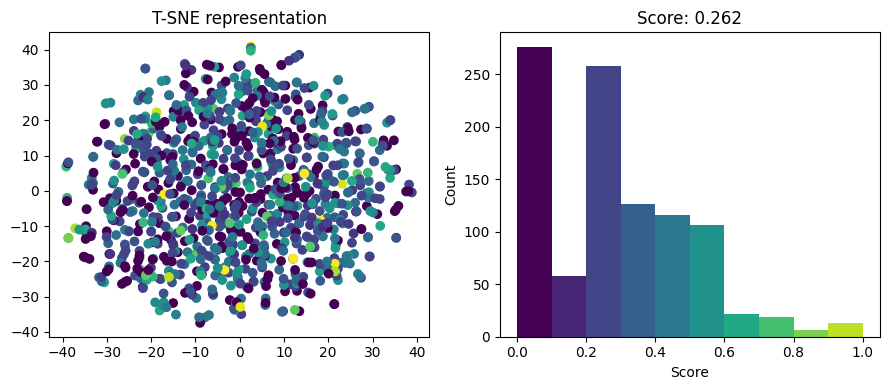

In [10]:
plot_model(tfidf_results[0], tfidf_results[2], tfidf_results[3])

De par son fonctionnement, **TF-IDF ne propose pas les tags les plus fréquents**, tels que les noms de langages informatiques ou bibliothèques régulièrement utilisées : c'est là une des limites de cette approche simple.

# <a id='toc4_'></a>[CountVectorizer](#toc0_)

Ce modèle simple compte le **nombre d'occurrences de chaque terme pour chaque document** et renvoie une matrice de la même forme que TF-IDF.

[Documentation ScikitLearn](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)

Modèle de comptage vectoriel avec au moins 10 occurrences dans le corpus :

In [11]:
count_vectorizer = CountVectorizer(token_pattern=r"\S+", dtype=np.uint16, min_df=10)

Entraînement

In [12]:
cv_fitted = count_vectorizer.fit(X_train)
cv_names = count_vectorizer.get_feature_names_out()

Résultats sur l'échantillon de test

Score:  0.234 - Duration:  16.0


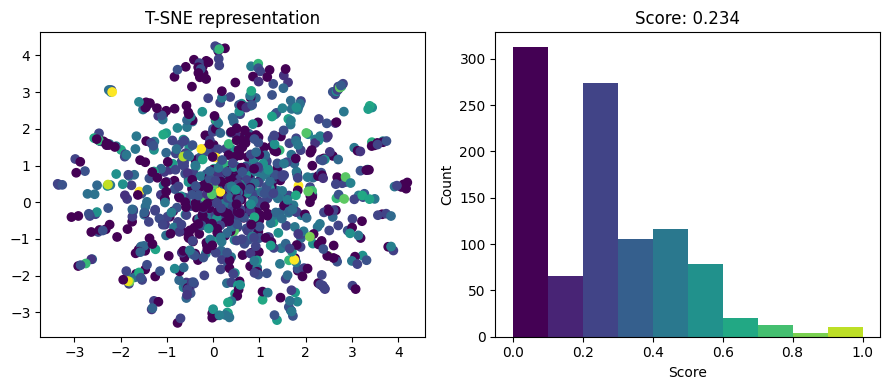

In [13]:
cv_results = score_reduce(cv_names, cv_fitted.transform(X_test), y_test)
plot_model(cv_results[0], cv_results[2], cv_results[3])

# <a id='toc5_'></a>[LDA](#toc0_)

*Latent Dirichlet Allocation*, signifie que l'on cherche les distribution de probabilités (*Dirichlet*) cachées dans le document (*latent*).

Il s'agit d'un modèle basé sur les **topics (*sujets*) d'un corpus**, visant à déterminer un sujet pour chaque document.  
Chaque sujet est représenté par un ensemble de termes qui le caractérisent, ce qui se traduit par des poids qui diffèrent pour chaque terme du corpus selon le sujet.

Puisque l'ordre des mots ne compte pas dans ce type de modèle, on appelle cette approche une **approche "bag-of-words"**.

LDA renvoie une matrice avec des **probabilités attribués aux différents sujets**, ce pour chaque document.

Pour résumer : chaque document est une distribution de probabilités de sujets et chaque sujet est une distribution de probabilités de termes.

Techniquement, LDA attribue un **sujet au hasard au départ et ajuste par itérations successives**.

L'**interprétation humaine** de chaque sujet est importante car elle seule permet de trouver un sens aux sujets.

[Documentation ScikitLearn](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html)

[pyLDAvis for visualization](https://medium.com/@sherryqixuan/topic-modeling-and-pyldavis-visualization-86a543e21f58)

[LDA in TDS](https://towardsdatascience.com/topic-modeling-quora-questions-with-lda-nmf-aff8dce5e1dd)

LDA prend une matrice de vecteurs en entrée : d'après diverses documentations et nombre d'utilisateurs, on obtient de meilleurs résultats avec une vectorisation par comptage plutôt que par fréquence.  
Utilisation de CountVectorizer :

In [15]:
cv = CountVectorizer(token_pattern=r"\S+", dtype=np.uint16, min_df=10)
cv_data = cv.fit_transform(X_train)
cv_names = cv.get_feature_names_out()

Évaluation de la perplexité pour déterminer un nombre de sujets adequat (processus long ≈ 10' : à lancer une seule fois)

In [16]:
%%script echo "no execution" # comment line for cell execution
perplexities = eval_lda_n_topics(random_state, cv_data)

DEBUG:asyncio:Using selector: EpollSelector


no execution # comment line for cell execution


<img src="outputs/LDA%20perplexities.png" width=600>

Selon la documentation, plus la perplexité est basse, plus le modèle est efficace.  
Le choix a été fait de tester sur des nombres cohérents de sujets : assez nombreux pour ne pas trop baisser le nombre de mots-clés, assez restreints pour qu'ils restent distincts et interprétables.

D'après ces résultats, **réduire les questions à 20 sujets principaux paraît le plus judicieux**.

In [17]:
# define a maximum number of topics (each represented by some words)
n_topics = 20

# LDA model
lda = LatentDirichletAllocation(
    n_components=n_topics,
    max_iter=5,
    learning_method="online",
    learning_offset=50.0,
    random_state=random_state,
)

Entraînement

In [18]:
lda.fit(cv_data)

LatentDirichletAllocation(learning_method='online', learning_offset=50.0,
                          max_iter=5, n_components=20, random_state=42)

Affichage des topics

In [19]:
n_top_words = 10
topics = get_topics(lda, cv_names, n_top_words)
topics

['server user request api app client web service token access',
 'array element list key number plot algorithm vector set map',
 'text header search add location option fragment custom design box',
 'django bar color aws flutter background notification set disable widget',
 'class java project interface parent maven configuration method properties dependency',
 'time google video task loop app stream second play crash',
 'object function component get json data react firebase event call',
 'function type c++ compiler compile gcc types program c standard',
 'test spring exception method boot unit service testing controller mock',
 'string database table data query sql field format name entity',
 'ios xcode app swift sdk target b apple cpu r',
 'project studio visual folder build node window npm app typescript',
 'version command python module package get script install build installed',
 'image view page button html click angular display browser screen',
 'windows certificate chrome get

Avec la librairie pyLDAvis

In [20]:
pyLDAvis.enable_notebook()
vis_lda = pyLDAvis.lda_model.prepare(lda, cv_data, cv, mds='tsne')

In [21]:
pyLDAvis.display(vis_lda)
# pyLDAvis.save_html(vis_lda, "outputs/LDA_topics.html")  # uncomment for HTML export

Application aux données de test

In [22]:
# predict
X_cv = cv.transform(X_test)
X_lda = lda.transform(X_cv)

Essai sur un exemple

In [23]:
n_top_topics = 5  # best topics for each input

# get the n top topics
top_topics = X_lda[random_i].argsort()[: -n_top_topics - 1 : -1]
# get its weights
top_topics_weights = X_lda[random_i][top_topics]

print(f"🔹 Original document:\n\t{origin_doc[['title', 'body']].values}\n")
print(f"🔹 Preprocessed data:\n\t{doc}\n")
# predict topics
print(f"🔹 Top {n_top_topics} topics:")
for topic in top_topics:
    print(f"\tTopic {topic} (weight {X_lda[random_i][topic]}):\n\t\t{topics[topic]}")

🔹 Original document:
	['Can I find an element using regex with Python and Selenium?'
 "<p>I need to click a dropdown list and click a hidden element with in it. the html will be generated by javascript and I won't know the id or class name but I will know it will have a phrase in it. Can I find and element by regex and then click it with selenium?</p>\n"]

🔹 Preprocessed data:
	find element regex python selenium click dropdown list click hidden element html generated javascript class name phrase find element regex click selenium

🔹 Top 5 topics:
	Topic 1 (weight 0.27396055875817643):
		array element list key number plot algorithm vector set map
	Topic 2 (weight 0.2161810021359828):
		text header search add location option fragment custom design box
	Topic 13 (weight 0.17620185472022845):
		image view page button html click angular display browser screen
	Topic 14 (weight 0.12752335285953495):
		windows certificate chrome get github local debug download update open
	Topic 4 (weight 0.07

La visualisation des topics est efficace mais on souhaite la prédiction de 5 tags à partir des topics.

## <a id='toc5_1_'></a>[Topic → prédiction de mots](#toc0_)

Un produit matriciel permet de conjuguer les poids des topics et des mots qu'ils contiennent

In [24]:
test_tags_weights = X_lda.dot(lda.components_)

Il est désormais possible de procéder aux prédictions et au score

In [25]:
# individual prediction
pred_weights = test_tags_weights[random_i]
pred_indices = np.argsort(pred_weights)[-5:][::-1]
pred_words = cv_names[pred_indices]

y = y_test[example_doc_index]

print(f"🔹 Words prediction:\n\t{pred_words}\n")
print(f"🔹 Targetted tags:\n\t{y}\n")
print(f"🔹 Score:\n\t{score_terms(pred_words, y)}\n")

🔹 Words prediction:
	['image' 'array' 'element' 'view' 'page']

🔹 Targetted tags:
	javascript python html regex selenium

🔹 Score:
	0.0



Résultats sur l'échantillon de test

Score:  0.064 - Duration:  18.0


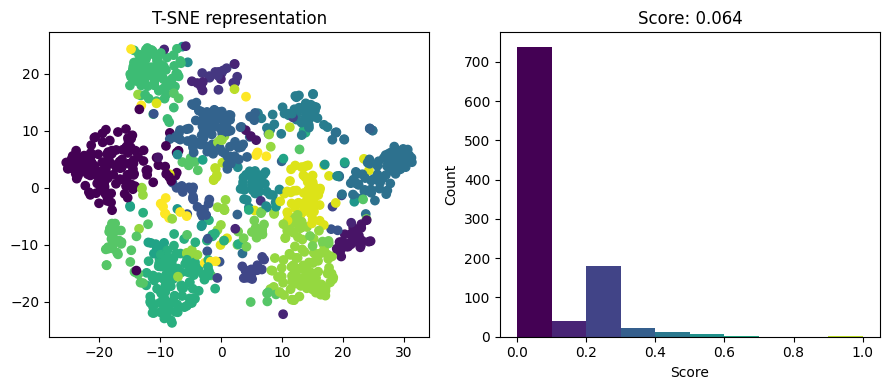

In [26]:
# compute results
lda_results = score_reduce(cv_names, X_lda, y_test, model=lda, model_type="topic")

# get top topic for each question (for color plot)
top_topics = [xi.argsort()[:-2: -1][0] for xi in X_lda]

# plot it
plot_topic_model(lda_results[0], lda_results[2], lda_results[3], top_topics)

# <a id='toc6_'></a>[NMF](#toc0_)

**Non-negative Matrix Factorization** est un ensemble d'algorithmes d'algèbre linéaire qui permettent d'identifier la structure de deux matrices non-négatives.  
Cela permet de dégager des sujets de documents, tout comme LDA.

Elle prend également en entrée une matrice de termes par document et un nombre défini de sujets.

<img src="https://www.researchgate.net/profile/Andrea-Bertozzi/publication/312157184/figure/fig1/AS:448453387001860@1483931027472/Conceptual-illustration-of-non-negative-matrix-factorization-NMF-decomposition-of-a.png" width=600>

Fonction utilisée par NMF :

\begin{align}\begin{aligned}L(W, H) &= 0.5 * ||X - WH||_{loss}^2\\&+ alpha\_W * l1\_ratio * n\_features * ||vec(W)||_1\\&+ alpha\_H * l1\_ratio * n\_samples * ||vec(H)||_1\\&+ 0.5 * alpha\_W * (1 - l1\_ratio) * n\_features * ||W||_{Fro}^2\\&+ 0.5 * alpha\_H * (1 - l1\_ratio) * n\_samples * ||H||_{Fro}^2\end{aligned}\end{align}

Contrairement à LDA, elle utilise l'**algèbre linéaire** pour la modélisation de sujets.  
NMF est initialisée par défaut de manière non aléatoire, avec notamment l'algorithme NNDSVDa (Nonnegative Double Singular Value Decomposition), bien qu'il soit possible de l'initialiser avec un état aléatoire.

[Documentation ScikitLearn](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html)

[Crims Topic Modeling](https://www.researchgate.net/publication/312157184_Crime_Topic_Modeling)

Pour une meilleure comparaison, on garde le même nombre de topics que précédemment

In [27]:
nmf = NMF(n_components=n_topics)

NMF prend une matrice de vecteurs en entrée : cette fois, les usages et diverses documentations suggèrent davantage une utilisation d'une vectorisation par fréquences.  
Utilisation de TF-IDF :

In [28]:
tfidf = TfidfVectorizer(token_pattern=r"\S+", min_df=10)
tfidf_data = tfidf.fit_transform(X_train)
tfidf_names = tfidf.get_feature_names_out()

Entraînement

In [29]:
nmf.fit(tfidf_data)

NMF(n_components=20)

Affichage des topics

In [30]:
topics = get_topics(nmf, tfidf_names, n_top_words)
topics

['c++ time one thread memory gcc compiler difference output program',
 'android studio gradle project build visual version device plugin emulator',
 'test unit mock testing jest component junit coverage method integration',
 'request server header response api http client post get service',
 'image upload size opencv color background convert video camera save',
 'python install version package installed windows script pip command environment',
 'column dataframe pandas row rows spark date pyspark convert index',
 'spring boot security jpa configuration bean rest exception java controller',
 'page view button component text html element click chrome react',
 'core .net asp.net framework project web visual mvc nuget service',
 'object array string json convert key return get format field',
 'module project import package webpack folder typescript npm build react',
 'class method constructor methods static interface java instance call abstract',
 'app ios xcode device swift firebase flutt

In [31]:
vis_nmf = pyLDAvis.lda_model.prepare(nmf, tfidf_data, tfidf, mds='tsne')

/home/vscode/.env/lib/python3.11/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/home/vscode/.env/lib/python3.11/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/home/vscode/.env/lib/python3.11/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


In [32]:
pyLDAvis.display(vis_nmf)
# pyLDAvis.save_html(vis_nmf, "outputs/NMF_topics.html")  # uncomment for HTML export

Application aux données de test

In [33]:
X_tfidf = tfidf.transform(X_test)
X_nmf = nmf.transform(X_tfidf)

Essai sur le document d'exemple

In [34]:
top_topics = X_nmf[random_i].argsort()[: -n_top_topics - 1 : -1]
top_topics_weights = X_nmf[random_i][top_topics]

test_tags_weights = X_nmf.dot(nmf.components_)
pred_weights = test_tags_weights[random_i]
pred_indices = np.argsort(pred_weights)[-5:][::-1]
pred_words = tfidf_names[pred_indices]

print(f"🔹 Original document:\n\t{origin_doc[['title', 'body']].values}\n")
print(f"🔹 Preprocessed data:\n\t{doc}\n")
print(f"🔹 Top {n_top_topics} topics:")
for topic in top_topics:
    print(f"\tTopic {topic} (weight {X_nmf[random_i][topic]}):\n\t\t{topics[topic]}")
print(f"🔹 Words prediction:\n\t{pred_words}\n")
print(f"🔹 Targetted tags:\n\t{y}\n")
print(f"🔹 Score:\n\t{score_terms(pred_words, y)}\n")

🔹 Original document:
	['Can I find an element using regex with Python and Selenium?'
 "<p>I need to click a dropdown list and click a hidden element with in it. the html will be generated by javascript and I won't know the id or class name but I will know it will have a phrase in it. Can I find and element by regex and then click it with selenium?</p>\n"]

🔹 Preprocessed data:
	find element regex python selenium click dropdown list click hidden element html generated javascript class name phrase find element regex click selenium

🔹 Top 5 topics:
	Topic 16 (weight 0.05274930933025555):
		list element items item stream get dictionary return filter loop
	Topic 8 (weight 0.03245646928758468):
		page view button component text html element click chrome react
	Topic 12 (weight 0.019656978806889942):
		class method constructor methods static interface java instance call abstract
	Topic 5 (weight 0.015978331995454686):
		python install version package installed windows script pip command envir

Résultats sur l'échantillon de test

In [35]:
nmf_results = score_reduce(tfidf_names, X_nmf, y_test, model=nmf, model_type="topic")

Score:  0.125 - Duration:  19.0


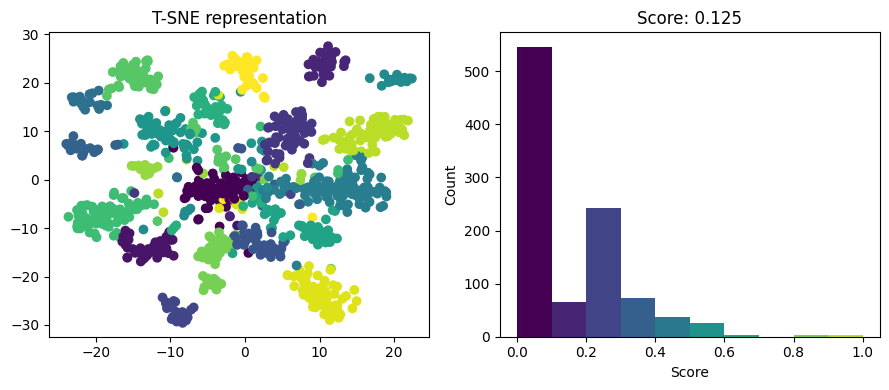

In [36]:
top_topics = [xi.argsort()[:-2: -1][0] for xi in X_nmf]
plot_topic_model(nmf_results[0], nmf_results[2], nmf_results[3], top_topics)

# <a id='toc7_'></a>[Conclusion](#toc0_)

> Aparté scores :  
> Les modèles testés sont du type BOW et ne peuvent proposer que des mots existant dans le corpus.  
> Or il a été précédemment constaté que les tags utilisateurs n'étaient représentés qu'à 52% dans le corpus, ce qui plafonne de facto les scores.

Les **modèles type BOW simples**, sans utilisation de topic, sont ceux qui obtiennent le meilleur score, notamment **TF-IDF**.  
Cependant, entre les modèles basés sur les topics, on constate que NMF propose de bien meilleures prédictions.

La **nécessité de tester d'autres modèles** apparaît toutefois, ce qui est l'objet d'un prochain notebook qui explore les modèles supervisés.

Enfin, une amélioration est d'ores-et-déjà possible dans ce cadre non-supervisé : l'utilisation de **$n$-grammes > 1** pourrait donner des résultats différents.